## 1.0a Taxi Data - Preprocessing -- Newest Version

In this first notebook, the main dataframe is preprocessed. This includes:
- Read and display datafile
- Checking data logic & removing invalid data
- Changing its datatypes
- Dropping trivial or null columns/rows
- Splitting the data into subsets and saving them for further work

As the original data is rather large in size, it is not included in the repository. Instead, when wanting to run this notebook, it is necessary to:
1. Download the data from https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew#column-menu where you specify via Actions->Query Data->Trip Start Timestamp // In Between // 2022 Jan 01 12:00:00 AM AND 2022 Dec 31 11:59:59 PM
2. Rename the file to "taxidata"
3. Run the code cell below and add the data to the following directory

There is a short description of each column of the dataset available at: https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz/about_data. In this notebook we assume that this information is known and refer to it. 

In [113]:
import os
# this directory for the original data file
os.makedirs('./data', exist_ok=True)
# this directory to later save the prepared data
os.makedirs('./data/prepped', exist_ok=True)

In [114]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Geospatial libraries
from h3 import h3 
import geopandas as gp
from shapely.geometry.polygon import Polygon

### 1.1 Read and display datafile

Data file not included in the project, needs to be downloaded individually. This step can take a few minutes due to size of the original file

In [115]:
df = pd.read_csv("data/taxidata.csv")

In [116]:
df.head(3)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31T23:45:00.000,2023-01-01T00:15:00.000,2081.0,4.42,NaN,NaN,2.0,3.0,...,0.0,20.50,Prcard,Flash Cab,42.001571,-87.695013,POINT (-87.6950125892 42.001571027),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,812.0,0.00,NaN,NaN,8.0,24.0,...,0.0,16.57,Mobile,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)
2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,600.0,0.90,NaN,NaN,8.0,8.0,...,3.0,12.00,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


In [117]:
print('Nr. of rows:')
print(df.shape[0])

Nr. of rows:
6382425


In [118]:
# Data types
df.dtypes

trip_id                        object
taxi_id                        object
trip_start_timestamp           object
trip_end_timestamp             object
trip_seconds                  float64
trip_miles                    float64
pickup_census_tract           float64
dropoff_census_tract          float64
pickup_community_area         float64
dropoff_community_area        float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location       object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location      object
dtype: object

### 1.2 Checking data logic & removing invalid data

In the following section we will investigate the data for its validity. The location related data will be handled separately in a later section since it requires additional effort. 

#### 1.2.1 Time related features

In [119]:
# Convert time types to check if entries are from correct range
df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
df["trip_end_timestamp"] = pd.to_datetime(df["trip_end_timestamp"])

# In range of 2022:
print(f"Min date: {df['trip_start_timestamp'].min()}")
print(f"Max date: {df['trip_start_timestamp'].max()}")

# Convert other 
df["trip_seconds"] =  pd.to_numeric(df['trip_seconds'])

Min date: 2022-01-01 00:00:00
Max date: 2022-12-31 23:45:00


Make sure these are the right dates, here it should say **2022-01-01 00:00:00** and **2022-12-31 23:45:00**. 

Drop trips with start_time > end_time:

In [120]:
print("Number of invalid time entries: ",len(df[df['trip_end_timestamp'] < df['trip_start_timestamp']]))

Number of invalid time entries:  122


In [121]:
invalid_time = df[df['trip_end_timestamp'] < df['trip_start_timestamp']].index

df = df.drop(invalid_time)

Add additional trip_hours feature for better intuitive understanding of the time compared to trip_seconds:

In [122]:
df['trip_hours'] = df['trip_seconds'] / 3600

#### 1.2.2 Duplicate entries

In [123]:
# Check duplicates 
print("Number of duplicate entries: ", df.duplicated().sum())

Number of duplicate entries:  0


If one considers all columns there seem to be no features. But since we don't exactly know how the trip_id is derived and assigned in the data collection process, we check for duplicates without considering trip_id:

In [124]:
# columns not to consider
exclude_columns = ['trip_id']

# columns to consider
columns_to_consider = list(set(df.columns) - set(exclude_columns))

In [125]:
# Check duplicates 
print("Number of duplicate entries: ", df.duplicated(subset = columns_to_consider).sum())

Number of duplicate entries:  17551


Same with additionally taxi_id:

In [126]:
# columns not to consider
exclude_columns = ['trip_id', 'taxi_id']

# columns to consider
columns_to_consider = list(set(df.columns) - set(exclude_columns))

In [127]:
# Check duplicates 
print("Number of duplicate entries: ", df.duplicated(subset = columns_to_consider).sum())

Number of duplicate entries:  20282


It is very unlikely that two or more rows that share the same value for every column except for trip_id and taxi_id are no duplicates. So we decide to drop these additional duplicate rows:

In [128]:
df = df.drop_duplicates(subset = columns_to_consider, keep='first')

In [129]:
print('There still are ' + str(df.shape[0]) + ' rows in the dataset')

There still are 6362021 rows in the dataset


#### 1.2.3 Checking and handling NAN values 

In [130]:
# Look into NAN values
print(f"General shape of dataframe: {df.shape}")
print(df.isna().sum())

General shape of dataframe: (6362021, 24)
trip_id                             0
taxi_id                           353
trip_start_timestamp                0
trip_end_timestamp                210
trip_seconds                     1333
trip_miles                         56
pickup_census_tract           3745802
dropoff_census_tract          3694176
pickup_community_area          512313
dropoff_community_area         631574
fare                             3512
tips                             3512
tolls                            3512
extras                           3512
trip_total                       3512
payment_type                        0
company                             0
pickup_centroid_latitude       510051
pickup_centroid_longitude      510051
pickup_centroid_location       510051
dropoff_centroid_latitude      595868
dropoff_centroid_longitude     595868
dropoff_centroid_location      595868
trip_hours                       1333
dtype: int64


##### taxi_id:
We drop the 353 rows with NAN values, since its only a very small amount and there is no possibility to derive the missing values:

In [131]:
df = df.drop(df[( df['taxi_id'].isna() )].index)

##### trip_end_timestamp:

In [132]:
print('Nr. of rows where trip_end_timestamp is missing:')
print(df[( df['trip_end_timestamp'].isna() )].shape[0])

print('Nr. of rows where trip_end_timestamp is missing and also trip_seconds:')
print(df[( df['trip_end_timestamp'].isna() ) & ( df['trip_seconds'].isna() )].shape[0])

Nr. of rows where trip_end_timestamp is missing:
209
Nr. of rows where trip_end_timestamp is missing and also trip_seconds:
209


For every where trip_end_timestamp is missing, also trip_seconds is missing. So we can't calculate it and will drop these rows:

In [133]:
df = df.drop(df[( df['trip_end_timestamp'].isna() )].index)

##### trip_seconds:

For the rows with missing trip_seconds we can now calculate it from trip_start_timestamp and trip_end_timestamp (note that it is not an exact value, because the time stamps are rounded to 15 minutes):

In [134]:
print('Nr. of rows where trip_seconds is missing:')
print(df[( df['trip_seconds'].isna() )].shape[0])

Nr. of rows where trip_seconds is missing:
1123


In [135]:
mask = df['trip_seconds'].isna()
# Note that this is an estimate, as the time stamps are rounded to the nearest quarter of an hour.
df.loc[mask, 'trip_seconds'] = (df.loc[mask, 'trip_end_timestamp'] - df.loc[mask, 'trip_start_timestamp']).dt.total_seconds()

# also calculate the missing trip_hours from the new trip_seconds
df['trip_hours'] = df['trip_seconds'] / 3600

##### trip_miles:
We will drop rows with missing values, since there are only 56 of them and we don't see any possibility to derive it from the pickup and dropoff information since it does not contain information about the actual route of the trip:

In [136]:
print('Nr. of rows where trip_miles is missing:')
print(df[( df['trip_miles'].isna() )].shape[0])

Nr. of rows where trip_miles is missing:
56


In [137]:
df = df.drop(df[( df['trip_miles'].isna() )].index)

In [138]:
print(df.isna().sum())

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           3745273
dropoff_census_tract          3693575
pickup_community_area          511854
dropoff_community_area         631009
fare                             3509
tips                             3509
tolls                            3509
extras                           3509
trip_total                       3509
payment_type                        0
company                             0
pickup_centroid_latitude       509592
pickup_centroid_longitude      509592
pickup_centroid_location       509592
dropoff_centroid_latitude      595303
dropoff_centroid_longitude     595303
dropoff_centroid_location      595303
trip_hours                          0
dtype: int64


##### fare to trip_total:

In [139]:
print('Nr of rows where everything from fare to trip_total is missing: ' + str(df[( df['fare'].isna() ) & ( df['tips'].isna() ) & ( df['tolls'].isna() ) & ( df['extras'].isna() ) & ( df['trip_total'].isna() )].shape[0]))

Nr of rows where everything from fare to trip_total is missing: 3509


This matches with the number of missing values in each of the single columns. So if one component of the total trip costs is missing, every other component is also missing. Since we have no possiblity to derive these values and there are only 3.512 of more than 6.000.000 rows affected, we drop these rows:

In [140]:
df = df.drop(df[( df['trip_total'].isna() )].index)

In [141]:
print(df.isna().sum())
print(df.shape[0])

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           3743504
dropoff_census_tract          3691862
pickup_community_area          511275
dropoff_community_area         630443
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude       509020
pickup_centroid_longitude      509020
pickup_centroid_location       509020
dropoff_centroid_latitude      594770
dropoff_centroid_longitude     594770
dropoff_centroid_location      594770
trip_hours                          0
dtype: int64
6357894


Now we removed all nan values, except for the location related features. They will be handled later in section 1.3.

#### 1.2.4 trip_total logic

From the source of the dataset we know that fare, tips, tolls, and extras should add up to the amount trip_total states, whereby cash tips will generaly not be recorded. Check if this is true and if trip_total is valid:

In [142]:
df_costs = df

df_costs = df_costs[['fare', 'tips', 'tolls', 'extras', 'trip_total']].copy()

In [143]:
def check_and_calculate_deviation_of_cost_components_to_total_amount(df_costs):
    # columns to sum
    columns_to_sum = ['fare', 'tips', 'tolls', 'extras']

    # check if the sum of the specified columns equals the trip_total
    check_sum = df_costs[columns_to_sum].sum(axis=1) == df_costs['trip_total']

    # calculate the difference
    sum_diff = df_costs['trip_total'] - df_costs[columns_to_sum].sum(axis=1)

    return check_sum, sum_diff

In [144]:
check_sum, sum_diff = check_and_calculate_deviation_of_cost_components_to_total_amount(df_costs)

df_costs['check_sum'] = check_sum
df_costs['sum_diff'] = sum_diff

In [145]:
print('The trip_total deviates from the sum of the other cost related columns in ' + str(df_costs[~df_costs['check_sum']].shape[0]) + ' rows.')

The trip_total deviates from the sum of the other cost related columns in 1842878 rows.


Check how large these differences are or if they could be just be caused by cash tips not recorded in the tips column but somehow consideration in the total_trip column for example if the drivers manually record it only in the total_trip amount:

In [146]:
# only consider the rows where the sum is not matching
print(df_costs[~df_costs['check_sum']]['sum_diff'].describe())

count    1.842878e+06
mean     5.424019e-01
std      4.185221e-01
min     -1.818989e-12
25%      5.000000e-01
50%      5.000000e-01
75%      5.000000e-01
max      2.500000e+01
Name: sum_diff, dtype: float64


We can see that the deviation is not large in the mean. Also the largest deviation in to the negative is small. Only the maximum positiv deviation is a higher value. Check the distribution of the deviations by again only considering these rows, where the sum is not matching. The x-limits are derived from the stistics above:

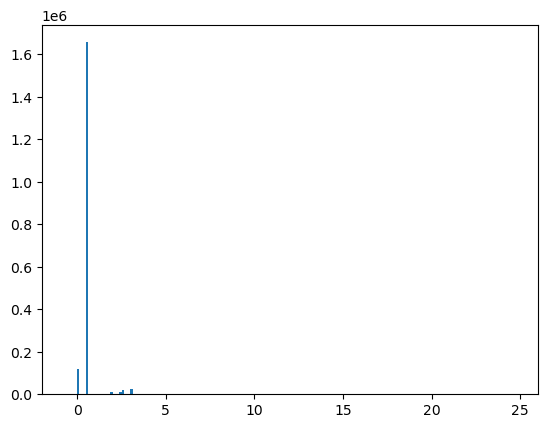

In [147]:
plt.hist(df_costs[~df_costs['check_sum']]['sum_diff'], bins=200)
plt.xlim(-2,26)
plt.show()

Here we also see that most deviations are very small and under five dollars. Now only consider larger deviations of more than five dollars:

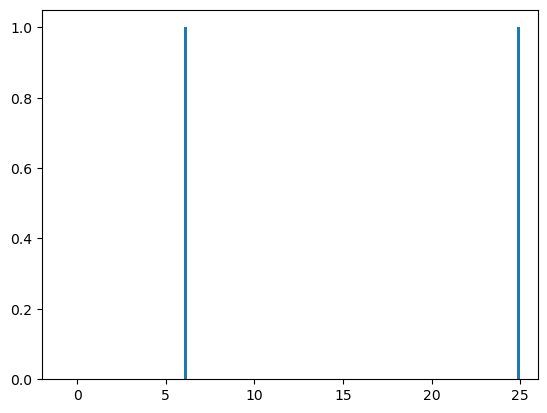

In [148]:
plt.hist(df_costs[( df_costs['sum_diff'] > 5 ) | ( df_costs['sum_diff'] < -5 )]['sum_diff'], bins=100)
plt.xlim(-2,26)
plt.show()

There are only 2 cases where the sum deviates more than five dollars. We evaluate all of these deviations as not critical, since they mostly are very small and could be the result of not separately recorded cash tips. We will also keep the rows with the larger deviations for now, since the adjustment for outliers is just about to follow in the next section.

#### 1.2.5 Check For Outliers

For numeric values we can check for outliers. This affects trip_seconds, trip_miles, fare, tips, tolls, extras and trip_total. In the following we start by looking at the three most important columns trip_seconds, trip_miles and trip_total since the other ones are subvalues of trip_total:

In [149]:
# definition of plotting functions
def three_feature_boxplots(df):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].boxplot(df['trip_seconds'])
    axs[0].set_title('Boxplot for trip_seconds')
    axs[0].set_xlabel('trip_seconds')
    axs[0].set_ylabel('Values')
    
    axs[1].boxplot(df['trip_miles'])
    axs[1].set_title('Boxplot for trip_miles')
    axs[1].set_xlabel('trip_miles')
    
    axs[2].boxplot(df['trip_total'])
    axs[2].set_title('Boxplot for trip_total')
    axs[2].set_xlabel('trip_total')
    
    plt.tight_layout()
    plt.show()

def two_feature_boxplots(df):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].boxplot(df['trip_seconds'])
    axs[0].set_title('0 Miles Trips - Distribution Of trip_seconds')
    axs[0].set_xlabel('trip_seconds')
    axs[0].set_ylabel('Values')
    
    axs[1].boxplot(df['trip_total'])
    axs[1].set_title('0 Miles Trips - Distribution Of trip_total')
    axs[1].set_xlabel('trip_total')

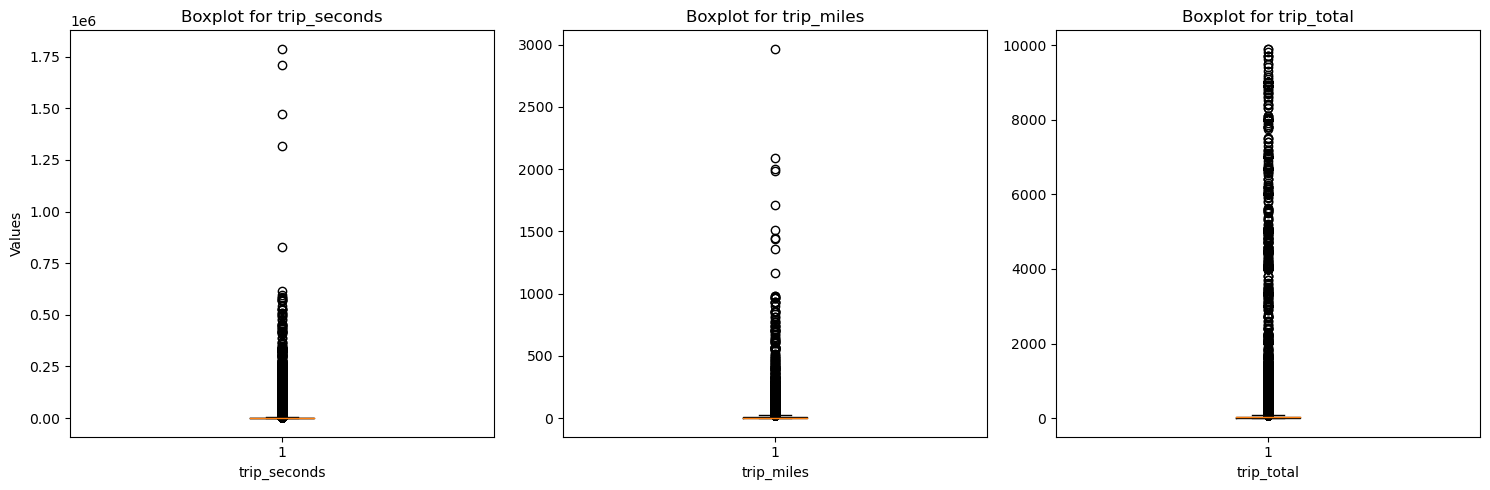

In [150]:
three_feature_boxplots(df)

We notice that there are some outliers with very high values that seem very unrealistic (e.g. trip_seconds > 1,000,000 (277 hours) or miles > 2.000) and we should eliminate. But before doing that we also notice that the means are very close to zero which seems strange, so we investigate this in the following:

In [151]:
# Number of equal zero entries
print("Number of zero entries for trip_seconds: ", len(df[df["trip_seconds"] == 0]))
print("Number of zero entries for trip_miles: ", len(df[df["trip_miles"] == 0]))
print("Number of zero entries for trip_total: ", len(df[df["trip_total"] == 0]))

Number of zero entries for trip_seconds:  147872
Number of zero entries for trip_miles:  785016
Number of zero entries for trip_total:  5522


There is a high number of trips with trip_miles or trip_seconds equalling zero (about 12% of 6,300,000 original entries in the case of trip_miles = 0). This does not fit to a typical taxi trip. A possible explanation could be that these are cancelled trips.

#### 1.2.5 a) Cancelled Trips Logic:
We could consider a trip cancelled if
- trip_miles = 0
- trip_seconds = 0
- pickup = dropoff (regarding centroid location) 

We don't consider trip_total cause there might be differing canceling charges depending on journey to the customer and potential waiting time (e.g. additional costs for amount of customers, idle time, etc.)

In [152]:
condition_geolocation = (df['pickup_centroid_location'].notna()) & (df['dropoff_centroid_location'].notna()) & (df['pickup_centroid_location'].notna() == df['dropoff_centroid_location'].notna())

condition = (condition_geolocation & ( df['trip_miles'] == 0 ) & ( df['trip_seconds'] == 0 )) 

df_cancelled = df[condition]
print(f'Number of cancelled trips: {df_cancelled.shape[0]}')

Number of cancelled trips: 107371


This cancelled trips logic only explains about 107,000 of the 785,000 trips with 0 trip_miles. Since we dont have location data for every trip, this could be a possible explanation why the number is not higher. So we remove that condition for a cancelled trip:

In [153]:
condition = (( df['trip_miles'] == 0 ) & ( df['trip_seconds'] == 0 )) 
df_cancelled = df[condition]
print(f'Number of cancelled trips: {df_cancelled.shape[0]}')

Number of cancelled trips: 140933


This can still only explain about 140,000 trips. We investigate the distribution of the trip_seconds of trips with 0 trip_miles. Maybe the trip_seconds count some waiting time before a trip is really cancelled:

In [154]:
df_miles_zero = df[df['trip_miles'] == 0]

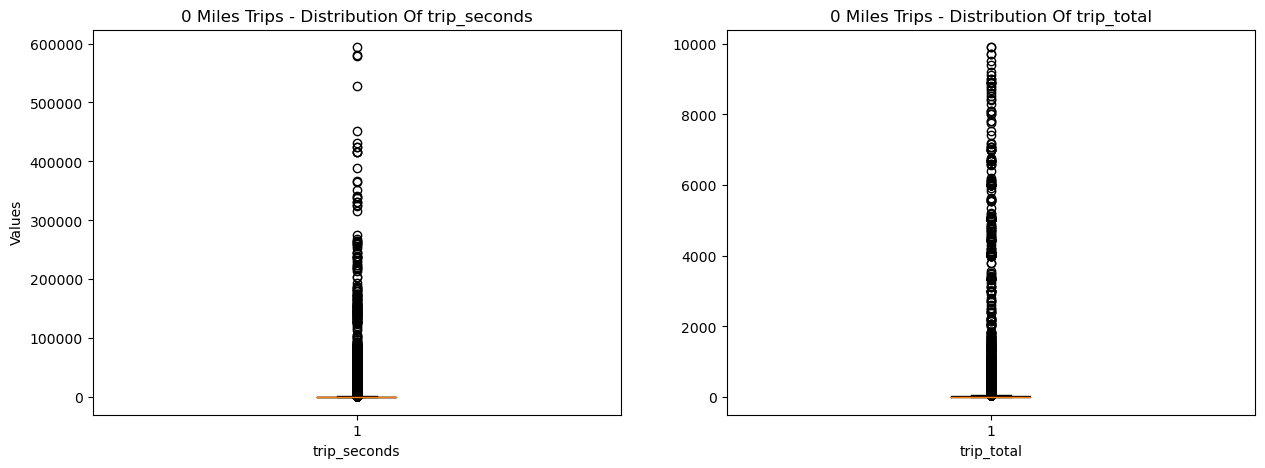

In [155]:
two_feature_boxplots(df_miles_zero)

We observe that the median in both features is very close to zero, which could be an indication that the waiting-time hypothesis is true, the low total costs in most of the trips support our considerations. Furthermore there are some unrealistic outliers, trips that last longer than several hours. We further analyze the values and notice that the first 50% of smallest values of trip_seconds are smaller or equal 300 seconds, which is 5 minutes and seems short for a typical taxi trip:

In [156]:
print(df_miles_zero['trip_seconds'].describe())

count    785016.000000
mean        622.521887
std        3692.954513
min           0.000000
25%           7.000000
50%         300.000000
75%         720.000000
max      594000.000000
Name: trip_seconds, dtype: float64


If we look at the distribution of trip_seconds of the not 0-miles trips, we observe that the values are much higher (50% = 960 seconds = 16 minutes):

In [157]:
print(df[df['trip_miles']!=0]['trip_seconds'].describe())

count    5.572878e+06
mean     1.313434e+03
std      3.305609e+03
min      0.000000e+00
25%      5.300000e+02
50%      9.600000e+02
75%      1.713000e+03
max      1.788300e+06
Name: trip_seconds, dtype: float64


So we relax the trip_seconds condition for cancelled trips to 300 seconds (=5 minutes) which seems like a realistic waiting-time for an ordered taxi before a trip is cancelled and can explain half of the 0-miles trips:

In [158]:
condition = (( df['trip_miles'] == 0 ) & ( df['trip_seconds'] <= 300 )) 
df_cancelled = df[condition]
df_no_cancelled = df[~condition]
print(f'Number of cancelled trips: {df_cancelled.shape[0]}')

Number of cancelled trips: 398593


In [159]:
print('Number of zero entries in trips that are not considered as cancelled:')
print("Number of zero entries for trip_seconds: ", len(df_no_cancelled[df_no_cancelled["trip_seconds"] == 0]))
print("Number of zero entries for trip_miles: ", len(df_no_cancelled[df_no_cancelled["trip_miles"] == 0]))
print("Number of zero entries for trip_total: ", len(df_no_cancelled[df_no_cancelled["trip_total"] == 0]))

Number of zero entries in trips that are not considered as cancelled:
Number of zero entries for trip_seconds:  6939
Number of zero entries for trip_miles:  386423
Number of zero entries for trip_total:  2114


We can neglect the zero entries w.r.t trip_seconds and trip_total since these are only a small fraction of our originally about 6,300,000 entries. But the zero entries for trip_miles are still 385,000 which is about 6% of the number of original entries. Looking at the distribution of trip_seconds and trip_total, we can't really explain them. In some cases we might still look at cancelled trips with longer waiting time than the assumed 5 minutes, in other cases the trip_miles might be zero due to recording or data transmission issues or the whole entry is debatable (e.g. in the case of more than 24 hours trip duration or cost of more than 8,000 dollars):

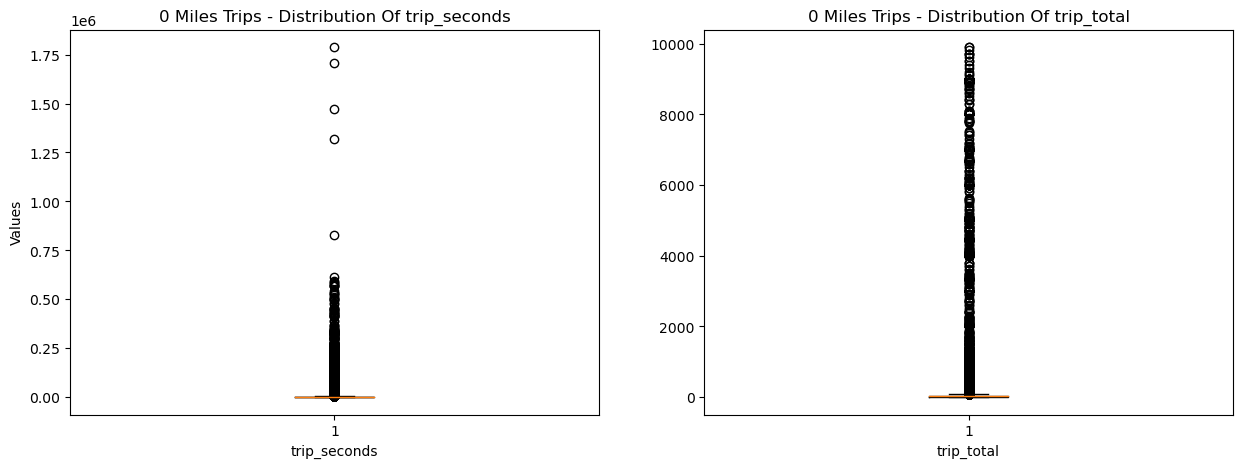

In [160]:
two_feature_boxplots(df_no_cancelled)

##### Conclusion:
In our further analysis tasks (descriptive, clustering, predicting) we only want to consider entries that seem to represent valid taxi trips. Cancelled trips dont play a significant role in our project scope. Thats why we remove the entries with 0-miles that we could classify as probably cancelled trips. Furthermore we also remove the rest of the entries that have 0-values for trip_miles, trip_seconds or trip_total, because we can't explain where these 0-values originate and we can't be sure if they are valid recordings or not. We want to avoid that these entries distort our later results:

In [161]:
df = df[(df['trip_miles'] > 0) & (df['trip_seconds'] > 0) & (df['trip_total'] > 0)]

#### 1.2.5 b) Remove Outliers

Now we return back to the elimination of extreme values and outliers in our dataset:

In [162]:
df_outliers = df

As a rule of thumb we consider everything that deviates more than 3-standard deviations from the mean as outlier:

In [163]:
def drop_outliers(df, column, mean, std):
    return df[(df[column] > mean - 3 * std) & (df[column] < mean + 3 * std)]

Calculate outliers on the whole current dataset, before dropping rows that are outliers in another column:

In [164]:
std_trip_seconds = df_outliers['trip_seconds'].describe(include='all').loc['std']
mean_trip_seconds = df_outliers['trip_seconds'].describe(include='all').loc['mean']

std_trip_miles = df_outliers['trip_miles'].describe(include='all').loc['std']
mean_trip_miles = df_outliers['trip_miles'].describe(include='all').loc['mean']

std_fare = df_outliers['fare'].describe(include='all').loc['std']
mean_fare = df_outliers['fare'].describe(include='all').loc['mean']

std_tips = df_outliers['tips'].describe(include='all').loc['std']
mean_tips = df_outliers['tips'].describe(include='all').loc['mean']

std_tolls = df_outliers['tolls'].describe(include='all').loc['std']
mean_tolls = df_outliers['tolls'].describe(include='all').loc['mean']

std_extras = df_outliers['extras'].describe(include='all').loc['std']
mean_extras = df_outliers['extras'].describe(include='all').loc['mean']

std_trip_total = df_outliers['trip_total'].describe(include='all').loc['std']
mean_trip_total = df_outliers['trip_total'].describe(include='all').loc['mean']

In [165]:
nr_rows_before = df_outliers.shape[0]

In [166]:
# drop outliers
df_outliers = drop_outliers(df_outliers, "trip_seconds", mean_trip_seconds, std_trip_seconds)
df_outliers = drop_outliers(df_outliers, "trip_miles", mean_trip_miles, std_trip_miles)
df_outliers = drop_outliers(df_outliers, "fare", mean_fare, std_fare)
df_outliers = drop_outliers(df_outliers, "tips", mean_tips, std_tips)
df_outliers = drop_outliers(df_outliers, "tolls", mean_tolls, std_tolls)
df_outliers = drop_outliers(df_outliers, "extras", mean_extras, std_extras)
df_outliers = drop_outliers(df_outliers, "trip_total", mean_trip_total, std_trip_total)

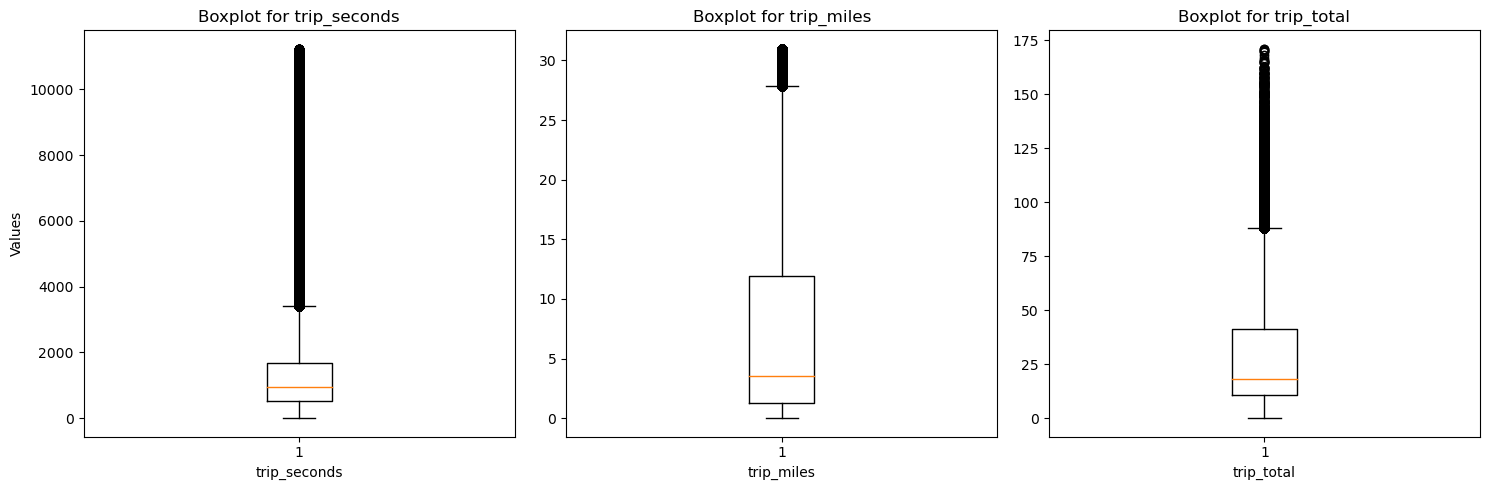

In [167]:
three_feature_boxplots(df_outliers)

After removal of outliers, the values seem much more reasonable. The largest trip_seconds is about 11,000 seconds which is about 3 hours. Still a high value, but a realistic exception. The median is about 1,000 seconds which is about 16 minutes and seems reasonable. The range of 0-30 miles seems also reasonable, just as the range of 0-175 dollars for trip_total. 

In [168]:
nr_rows_after = df_outliers.shape[0]
print('Number of removed entries after outlier elimination: ' + str(nr_rows_before - nr_rows_after))

Number of removed entries after outlier elimination: 83379


We dropped only about 80,000 from originally about 6,300,000 rows.

Now check again for the difference in the sum of cost components and total_trip amount. The rows with larger deviations are removed:

In [169]:
check_sum, sum_diff = check_and_calculate_deviation_of_cost_components_to_total_amount(df_costs)

df_outliers['sum_diff'] = sum_diff

print('Nr of rows with deviations larger than five dollars: ' + str(df_outliers[(df_outliers['sum_diff'] > 5) | (df_outliers['sum_diff']  < -5)].shape[0]))

Nr of rows with deviations larger than five dollars: 0


In [170]:
# continue working on the new dataset
df_outliers = df_outliers.drop('sum_diff', axis=1)
df = df_outliers

#### 1.2.6 Mph Logic

We want to conduct some further validity check for the taxi trips and remove trips that have impossible trip_miles to trip_seconds ratios since this indicates some discrepancy in the data. To have some orientation for the speed limit in Chicago/Cook County, we took this as a source: https://www.arcgis.com/home/item.html?id=5e279cbe89794bcba87809d9ae95594d which resulted in a limit of 65 mph for our taxi data, as anything above is unrealistic. Note that there still can be some unreasonable trips although the mph is smaller than 65, but it gives us a rough orientation and everything above is with fairly high certainty not reasonable and should be removed:

In [171]:
df['mph'] = np.where(df['trip_hours'] != 0, df['trip_miles'] / df['trip_hours'], np.nan)

Text(0, 0.5, 'values')

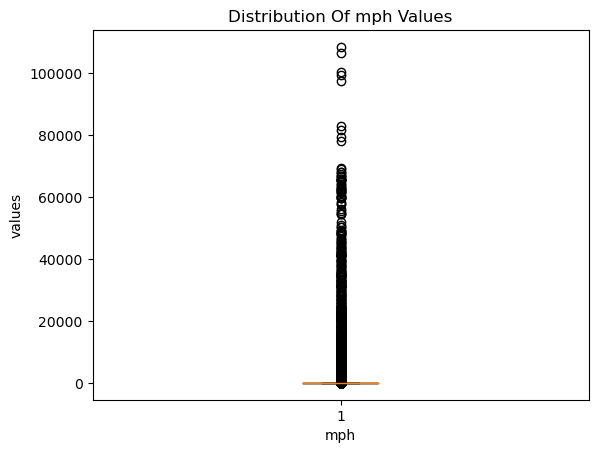

In [172]:
plt.boxplot(df['mph'])
plt.title('Distribution Of mph Values')
plt.xlabel('mph')
plt.ylabel('values')

In the plot we see that there actually are some really exaggerated values. We remove them.

In [173]:
nr_rows_before = df.shape[0]

In [174]:
# keep only entries with mph <= 65
df = df[(df["mph"] <= 65)]

In [175]:
nr_rows_after = df.shape[0]
print(f'Number of removed entries: {nr_rows_before-nr_rows_after}')

Number of removed entries: 8564


In [176]:
df = df.drop('mph', axis=1)

#### 1.2.7 Prepare Different Temporal Discretization

In order to analyze the data with respect to different temporal resolutions, we create some extra time features, all derived from the trip_start_timestamp as it indicates the start time of the trip. Moreover we add sinus and cosinus representations of each of these features in order to have more uniform distances between each of the time steps, which can be necesseray for the cluster analysis:

In [177]:
df['1_hour_window'] = df['trip_start_timestamp'].dt.hour
df['1_hour_window_sin'] = np.sin(df['1_hour_window']*(2.*np.pi/24))
df['1_hour_window_cos'] = np.cos(df['1_hour_window']*(2.*np.pi/24))

In [178]:
df['4_hour_window'] = df['trip_start_timestamp'].dt.floor('4h').dt.hour
df['4_hour_window_sin'] = np.sin(df['4_hour_window']*(2.*np.pi/24))
df['4_hour_window_cos'] = np.cos(df['4_hour_window']*(2.*np.pi/24))

In [179]:
df['6_hour_window'] = df['trip_start_timestamp'].dt.floor('6h').dt.hour
df['6_hour_window_sin'] = np.sin(df['6_hour_window']*(2.*np.pi/24))
df['6_hour_window_cos'] = np.cos(df['6_hour_window']*(2.*np.pi/24))

In [180]:
df['weekday']      = df['trip_start_timestamp'].dt.dayofweek
df['weekday_sin']  = np.sin(df['weekday']*(2.*np.pi/7))
df['weekday_cos']  = np.cos(df['weekday']*(2.*np.pi/7))

In [181]:
def plot_sin_cos_features(sin_feature, cos_feature, cycle):

    unique_points = df[[sin_feature, cos_feature]].drop_duplicates()

    plt.figure(figsize=(10, 5))
    plt.scatter(unique_points[sin_feature], unique_points[cos_feature], color='blue', alpha=0.5)
    plt.title(cycle + ' Cycle')
    plt.xlabel('Sinus')
    plt.ylabel('Cosinus')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

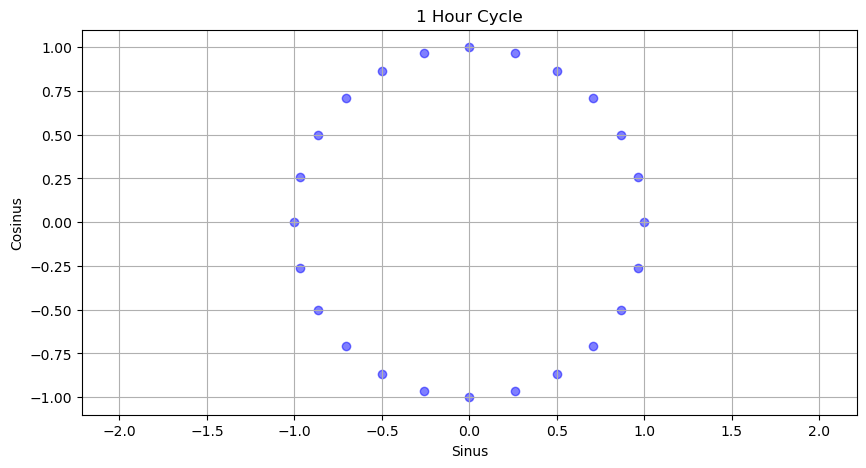

In [182]:
plot_sin_cos_features('1_hour_window_sin', '1_hour_window_cos', '1 Hour')

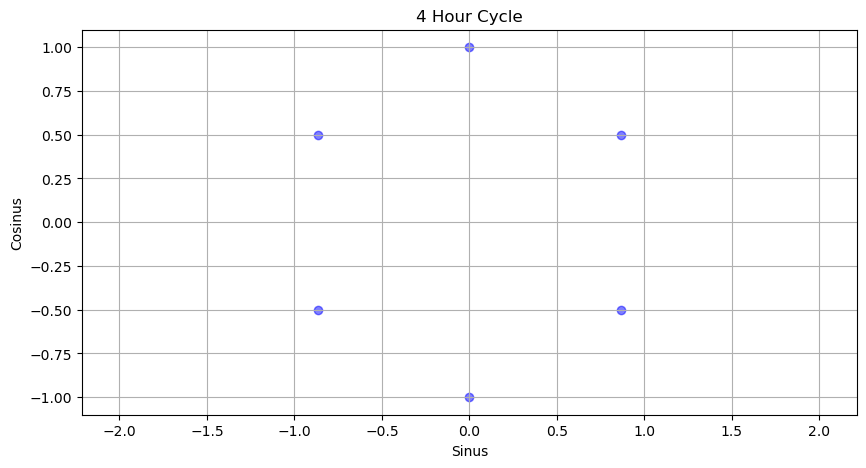

In [183]:
plot_sin_cos_features('4_hour_window_sin', '4_hour_window_cos', '4 Hour')

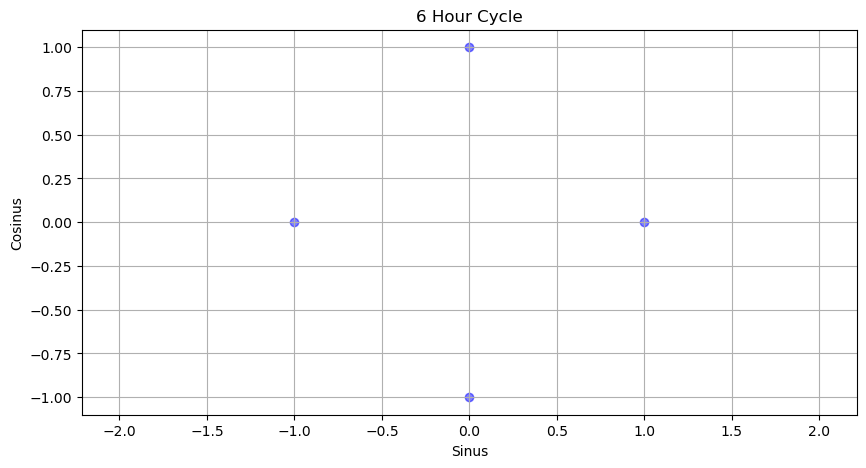

In [184]:
plot_sin_cos_features('6_hour_window_sin', '6_hour_window_cos', '6 Hour')

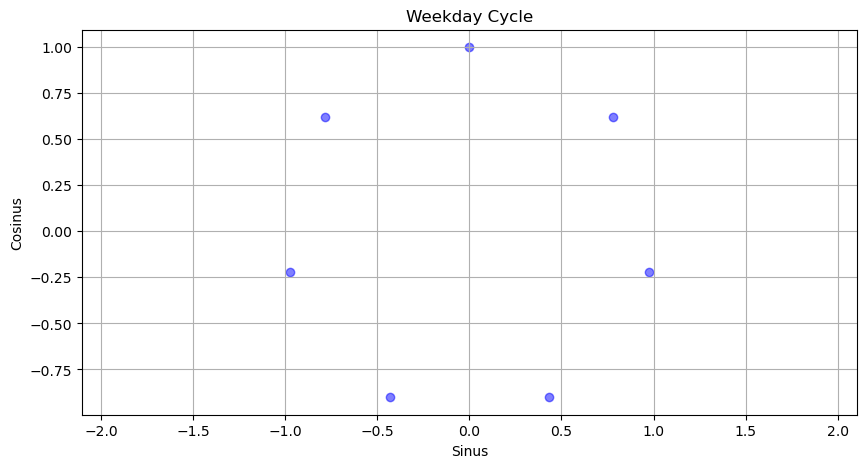

In [185]:
plot_sin_cos_features('weekday_sin', 'weekday_cos', 'Weekday')

### 1.2.8 Encode data

We encode categorical string features to numerical values to make them usable for our enhanced analysis tasks. This affects in particular the columns "taxi_id", "company" and "payment_type". 

In [186]:
def encode_and_save_mappings(df, columns, output_prefix='data/trips_mapping_'):
    for column in columns:
        df[f'{column}_encoded'] = pd.factorize(df[column])[0]
        
        mapping = df[[column, f'{column}_encoded']].drop_duplicates().sort_values(f'{column}_encoded')
        mapping.to_csv(f'{output_prefix}{column.lower().replace(" ", "_")}.csv', index=False)
        
        print(f"Mapping for {column} saved to {output_prefix}{column.lower().replace(' ', '_')}.csv")
        print(f"Check for correct mapping: \nNumber of unique entries: {len(df[column].unique())} \nNumber of mappings: {len(df[f'{column}_encoded'].unique())}")
    return df

In [187]:
columns_to_encode = ['payment_type', 'company', 'taxi_id']
df = encode_and_save_mappings(df, columns_to_encode)

Mapping for payment_type saved to data/trips_mapping_payment_type.csv
Check for correct mapping: 
Number of unique entries: 7 
Number of mappings: 7
Mapping for company saved to data/trips_mapping_company.csv
Check for correct mapping: 
Number of unique entries: 36 
Number of mappings: 36
Mapping for taxi_id saved to data/trips_mapping_taxi_id.csv
Check for correct mapping: 
Number of unique entries: 2823 
Number of mappings: 2823


### 1.3.1 Merging Community Area Data

In order to obtain the names of the pickup and dropoff community areas and the community areas itself where it is missing while having centroid_location available, we merge our dataset with a community area dataset from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6. 

In [188]:
# Import prepped community df
community_df = gp.read_file("data/prepped/community_df.geojson")

Merge the two datasets based on the coordinates. In our original dataset (df) we have coordinates (longitude and latitude) for each trip/row where it is available. From the Community Area dataset we have for each community area a multipolygon with coordinates that lie within this community area:

In [190]:
def merge_with_community_df(df, community_df, lat_col, lon_col, community_col, area_number_col, prefix, suffix):
    gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df[lon_col], df[lat_col]))
    gdf = gdf.rename_geometry(f"{prefix}_geometry")

    community_df = community_df.copy()
    # comment in for keeping geometry column from community_df
    #community_df[f"{prefix}_geometry_{suffix}"] = community_df['geometry']
    
    gdf.set_crs(epsg=4326, inplace=True)
    community_df.to_crs(epsg=4326, inplace=True)

    # Perform the spatial join
    merged_gdf = gp.sjoin(gdf, community_df, how="left", predicate="within")

    # Drop unnecessary columns
    merged_gdf = merged_gdf.drop([f"{prefix}_geometry", "index_right"], axis=1)

    # Rename columns
    merged_gdf = merged_gdf.rename(columns={
        community_col: f"{prefix}_community",
        area_number_col: f"{prefix}_area_number"
    })

    return pd.DataFrame(merged_gdf)

# Merge for pickup
df_merged = merge_with_community_df(df, community_df, 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'community', 'area_number', 'pickup', 'community')
# Merge for dropoff
df_merged = merge_with_community_df(df_merged, community_df, 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'community', 'area_number', 'dropoff','community')

In [191]:
df_merged.isna().sum()

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           3245620
dropoff_census_tract          3158086
pickup_community_area          437351
dropoff_community_area         493920
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude       436760
pickup_centroid_longitude      436760
pickup_centroid_location       436760
dropoff_centroid_latitude      461453
dropoff_centroid_longitude     461453
dropoff_centroid_location      461453
trip_hours                          0
1_hour_window                       0
1_hour_window_sin                   0
1_hour_windo

pickup_community and dropoff_community (from the community area dataset) represent the same values as pickup_community_area and dropoff_community_area (from the original dataset). Since we merged them based on the longitude and latitude where it is available, we dont have further opportunities to derive missing values. The location data is necessary for our further analysis tasks, thats why we drop the rows without any location data:

In [192]:
condition = (df_merged['pickup_area_number'].notna()) & (df_merged['dropoff_area_number'].notna())

df_merged = df_merged[condition]

In [193]:
df_merged.isna().sum()

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2574851
dropoff_census_tract          2574851
pickup_community_area             553
dropoff_community_area          26676
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
1_hour_window                       0
1_hour_window_sin                   0
1_hour_windo

Drop the columns pickup_community_area and dropoff_community_area since we have more complete values in the pickup_community and dropoff_community columns form the merged dataset:

In [194]:
df_merged = df_merged.drop(['pickup_community_area', 'dropoff_community_area'], axis=1)

Now we dont have any nan values left, except for census tract, which is mising in many cases according to the data description from the official website due to privacy and location reasons. We will keep them because it is missing in the majority of cases:

In [195]:
df_merged.isna().sum()

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2574851
dropoff_census_tract          2574851
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
1_hour_window                       0
1_hour_window_sin                   0
1_hour_window_cos                   0
4_hour_window                       0
4_hour_windo

For the spatial analysis we want to have the geometry column of the census tract for each entry for pickup and dropoff respecitvely. So we merge it with the census tract dataset and keep the respective columns:

In [196]:
# Import prepped community df
#census_df = gp.read_file("data/prepped/census_tracts_df.geojson")

In [197]:
# def merge_with_census_df(df, census_df, lat_col, lon_col, prefix, suffix):
#     gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df[lon_col], df[lat_col]))
#     gdf = gdf.rename_geometry(f"{prefix}_geometry")
    
#     census_df = census_df.copy()
#     census_df[f"{prefix}_geometry_{suffix}"] = census_df['geometry']
    
#     gdf.set_crs(epsg=4326, inplace=True)
#     census_df.to_crs(epsg=4326, inplace=True)

#     # Perform the spatial join
#     merged_gdf = gp.sjoin(gdf, census_df, how="left", predicate="within")

#     # Drop unnecessary columns
#     merged_gdf = merged_gdf.drop([f"{prefix}_geometry", "index_right", 'commarea', 'geoid10'], axis=1)

#     return pd.DataFrame(merged_gdf)

# # Merge for pickup
# df_merged = merge_with_census_df(df_merged, census_df, 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'pickup', 'census')
# # Merge for dropoff
# df_merged = merge_with_census_df(df_merged, census_df, 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff','census')

In [198]:
# df_merged.isna().sum()

The new nan values in the last two features result from one specific census tract which could not be found in the cenus tract dataset but some entries from the taxi trip data have that census tract assigned:

In [199]:
# print(df_merged[df_merged['dropoff_geometry_census'].isna()]['dropoff_census_tract'].unique())
# print(df_merged[df_merged['pickup_geometry_census'].isna()]['pickup_census_tract'].unique())

We keep them, because we have different location data available for them.

### 1.3.2 Hexagons 

In [200]:
# Get hex ids
def add_h3_ids(df, res):
    df[f"h3_res{res}_pickup"] = np.vectorize(h3.geo_to_h3)(
        df['pickup_centroid_latitude'], df['pickup_centroid_longitude'], res)
    df[f"h3_res{res}_dropoff"] = np.vectorize(h3.geo_to_h3)(
        df['dropoff_centroid_latitude'], df['dropoff_centroid_longitude'], res)
    return df

# Get poly from hex ids - vectorized form to save time
def poly_from_hex(df, colname, res):
    hex_ids = df[f"h3_res{res}_{colname}"].values
    polygons = np.vectorize(lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True)))(hex_ids)
    df[f"poly_res{res}_{colname}"] = polygons
    return df

# Get count for each trip happening in the same hexagon
def get_poly_count(df, colname):
    name = colname.split("_")[1] + "_" + colname.split("_")[2]
    df[f"count{name}"] = df.groupby(colname)['trip_id'].transform('count')
    return df

In [201]:
# For hexagon resolution, adapted: https://towardsdatascience.com/exploring-location-data-using-a-hexagon-grid-3509b68b04a2 table
df_merged = add_h3_ids(df_merged, 7)
df_merged = add_h3_ids(df_merged, 8)

#### Save Data

In [206]:
df_merged.to_parquet('data/prepped/prep_taxidata.parquet')

In [207]:
# read in
df = pd.read_parquet('data/prepped/prep_taxidata.parquet')